## Importing Neccessary Libraries

In [1]:
import os
import time
import shutil
import itertools
import random
# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import categorical_crossentropy


print ('modules loaded')

modules loaded


## preprocessing The Dataset

In [2]:
data_dir = 'hmnist_28_28_RGB.csv'
data = pd.read_csv(data_dir)
data.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


In [3]:
Label = data["label"]
Data = data.drop(columns=["label"])

In [4]:
data["label"].value_counts()


4    6705
6    1113
2    1099
1     514
0     327
5     142
3     115
Name: label, dtype: int64

##  randomly selecting examples from the minority class, with replacement, and adding them to the training dataset

In [5]:
from imblearn.over_sampling import RandomOverSampler   #augmentation

oversample = RandomOverSampler()
Data, Label  = oversample.fit_resample(Data, Label)
Data = np.array(Data).reshape(-1, 28, 28, 3)
print('Shape of Data :', Data.shape)

Shape of Data : (46935, 28, 28, 3)


In [6]:
Label = np.array(Label)
Label

array([2, 2, 2, ..., 6, 6, 6])

## Skin Cancer Classes

In [7]:
classes = {4: ('nv', ' melanocytic nevi'),
           6: ('mel', 'melanoma'),
           2 :('bkl', 'benign keratosis-like lesions'),
           1:('bcc' , ' basal cell carcinoma'),
           5: ('vasc', ' pyogenic granulomas and hemorrhage'),
           0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),
           3: ('df', 'dermatofibroma')}

## Splitting The Dataset Into Test Set And Training Set

In [8]:
from sklearn.model_selection import train_test_split

X_train , X_test , y_train , y_test = train_test_split(Data , Label , test_size = 0.25 , random_state = 49)

In [9]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(35201, 28, 28, 3)
(35201,)
(11734, 28, 28, 3)
(11734,)


In [11]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [12]:
y_train.shape

(35201, 7)

In [13]:
print(y_train[0])

[0. 0. 0. 1. 0. 0. 0.]


## Displaying Random Image from The Training Set

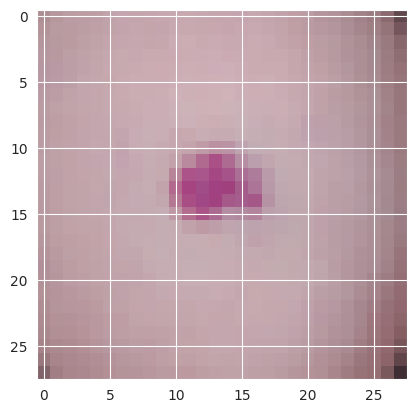

In [14]:
ind= random.randint(1,10000)
plt.imshow(X_train[ind], cmap='gray')
# plt.axis('off')
plt.show()

## Custom Callbacks For the learning rate

In [15]:
from keras.callbacks import ReduceLROnPlateau

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy'
                                            , patience = 2
                                            , verbose=1
                                            ,factor=0.5
                                            , min_lr=0.00001)

# Building CNN Training Model With Custom Hyperparameter Tuning

In [16]:
model = keras.models.Sequential()

# Create Model Structure
model.add(keras.layers.Input(shape=[28, 28, 3]))
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(rate=0.2))


model.add(keras.layers.Dense(units=128, activation='relu', kernel_initializer='he_normal'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(units=64, activation='relu', kernel_initializer='he_normal'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(units=32, activation='relu', kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.L1L2()))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(units=7, activation='softmax'))
model.compile(Adam(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 14, 14, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0

## Training The Model On Training Set

In [17]:
history = model.fit(X_train ,
                    y_train ,
                    epochs=25 ,
                    batch_size=128,
                    validation_data=(X_test , y_test) ,
                    callbacks=[learning_rate_reduction])
                #    )

Epoch 1/25
276/276 [==============================] - 13s 14ms/step - loss: 0.8303 - accuracy: 0.7091 - val_loss: 0.6613 - val_accuracy: 0.7513 - lr: 0.0010
Epoch 2/25
276/276 [==============================] - 2s 9ms/step - loss: 0.3461 - accuracy: 0.8780 - val_loss: 0.3311 - val_accuracy: 0.8758 - lr: 0.0010
Epoch 3/25
276/276 [==============================] - 3s 9ms/step - loss: 0.2214 - accuracy: 0.9225 - val_loss: 0.3116 - val_accuracy: 0.8875 - lr: 0.0010
Epoch 4/25
276/276 [==============================] - 2s 9ms/step - loss: 0.1628 - accuracy: 0.9423 - val_loss: 0.2814 - val_accuracy: 0.8965 - lr: 0.0010
Epoch 5/25
276/276 [==============================] - 2s 9ms/step - loss: 0.1221 - accuracy: 0.9569 - val_loss: 0.1476 - val_accuracy: 0.9497 - lr: 0.0010
Epoch 6/25
276/276 [==============================] - 2s 9ms/step - loss: 0.1066 - accuracy: 0.9624 - val_loss: 0.1686 - val_accuracy: 0.9417 - lr: 0.0010
Epoch 7/25
276/276 [==============================] - 2s 9ms/step - 

## Function To Plot Training v/s validation Loss, Training v/s validation Accuracy  

In [18]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

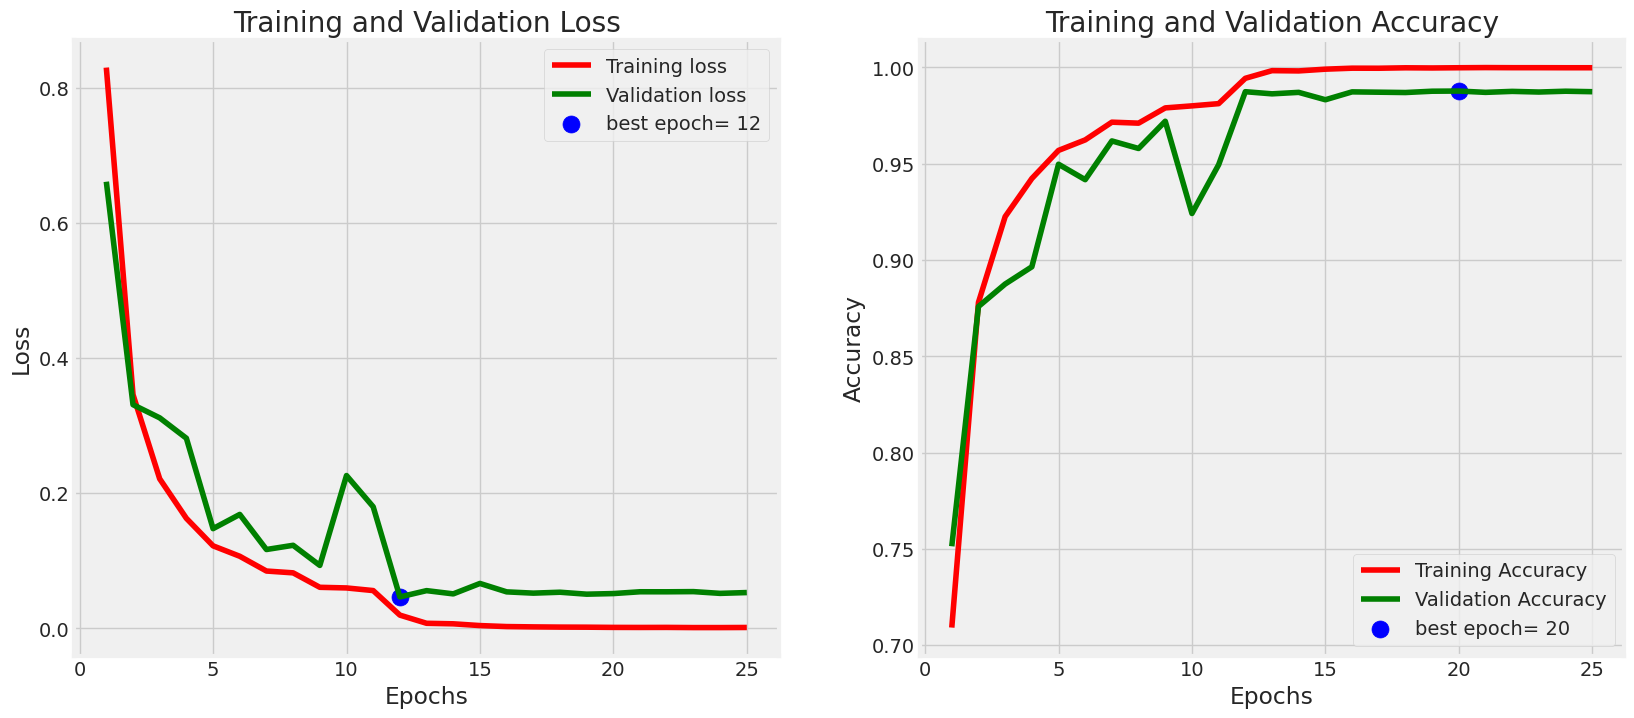

In [19]:
plot_training(history)


## Evaluating Model On Training And Test Set

In [20]:
train_score = model.evaluate(X_train, y_train, verbose= 1)
test_score = model.evaluate(X_test, y_test, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

367/367 [==============================] - 1s 3ms/step - loss: 0.0529 - accuracy: 0.9874
Train Loss:  8.805410470813513e-05
Train Accuracy:  1.0
--------------------
Test Loss:  0.052904024720191956
Test Accuracy:  0.9873870611190796


## Converting Test set to numpy array and predicting the values.

In [21]:
y_true = np.array(y_test)
y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred , axis=1)
y_true = np.argmax(y_true , axis=1)

367/367 [==============================] - 1s 2ms/step


## Creating List Of Classes Labels

In [22]:
classes_labels = []
for key in classes.keys():
    classes_labels.append(key)

print(classes_labels)

[4, 6, 2, 1, 5, 0, 3]


## Saving The CNN Model

In [24]:
model.save('Skin Cancer.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [26]:
import PIL

In [37]:
image = PIL.Image.open("/content/02-Blog_MelanocyticNevus_Aug2018 (1).jpg")
image = image.resize((28, 28))
img_reshape = np.array(image).reshape(-1, 28, 28, 3)

In [38]:
result = model.predict(img_reshape)

1/1 [==============================] - 0s 23ms/step


In [39]:
print(result[0])

[5.0898618e-03 7.4846120e-08 1.6063221e-02 1.0132939e-07 1.6851033e-01
 1.9007511e-02 7.9132891e-01]


In [40]:
classes[np.argmax(result[0])]

('mel', 'melanoma')